In [1]:
import pandas as pd
import numpy as np

In [2]:
!ls ../multilabel/ODIR/

 ODIR-5K_Testing_Images				  ODIR-5K_Training_Dataset
'ODIR-5K_Training_Annotations(Updated)_V2.xlsx'   XYZ_ODIR.csv


In [3]:
train_df = pd.read_excel('../multilabel/ODIR/ODIR-5K_Training_Annotations(Updated)_V2.xlsx')
train_df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1
3,3,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1
4,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1


In [4]:
test_df = pd.read_csv('../multilabel/ODIR/XYZ_ODIR.csv')
test_df.head()

,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,0,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0


In [5]:

from pytorch_lightning import seed_everything, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,LearningRateMonitor
import torch.nn.functional as F
from sklearn.utils import class_weight
from torchvision import transforms 
import torchvision.models as models
import torchmetrics
import torch#pytorch
from sklearn.utils import class_weight
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingWarmRestarts


2021-12-16 19:52:24.303796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [6]:
from albumentations import *

from albumentations.pytorch import ToTensorV2

aug= Compose([
            Resize(256, 256),
            CenterCrop(224,224),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(0.05,0.05,5), 
            RandomBrightnessContrast(p=0.5),
            CLAHE(),
            Cutout(p=0.5),
            Normalize(mean=(0,0,0), std=(1, 1, 1)),
            ToTensorV2(p=1.0),
        ], p=1.0,additional_targets={'image0': 'image'})


/home/talha/venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


In [25]:
train_path='../multilabel/ODIR/ODIR-5K_Training_Dataset/'

In [8]:
from PIL import Image
import cv2
from torch.utils.data import DataLoader, Dataset
class DataReader(Dataset):
  def __init__(self,df,path,transform=None):
    super(DataReader,self).__init__()
    self.df=df
    self.path=path
    self.transform=transform
  def __len__(self):
    return len(self.df)

  def __getitem__(self,index):
    image_path=self.df.iloc[index,0]
    image_label=self.df.iloc[index,-8::]
    #read data
    left=cv2.imread(self.path+str(image_path)+'_left.jpg')
    left=cv2.cvtColor(left,cv2.COLOR_BGR2RGB)
    right=cv2.imread(self.path+str(image_path)+'_right.jpg')
    right=cv2.cvtColor(right,cv2.COLOR_BGR2RGB)
    
    
    if self.transform:
        image=self.transform(image=left,image0=right)
        left=image['image']
        right=image['image0']

    return left,right,torch.tensor(image_label,dtype=torch.float32)

In [9]:
train=DataReader(train_df,train_path,aug)
train_loader = DataLoader(train,shuffle=True,num_workers=0,batch_size=16)
left,right,label=next(iter(train_loader))
print(left.shape,right.shape,label.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16, 3, 224, 224]) torch.Size([16, 8])


In [10]:
# mean,std=[],[]
# for x,_,_ in train_loader:
#     mean.append(torch.mean(x/255, dim=(0, 2,3)))
#     std.append(torch.std(x/255, dim=(0, 2,3)))
# print(np.mean(np.stack(mean),axis=0))
# print(np.mean(np.stack(std),axis=0))

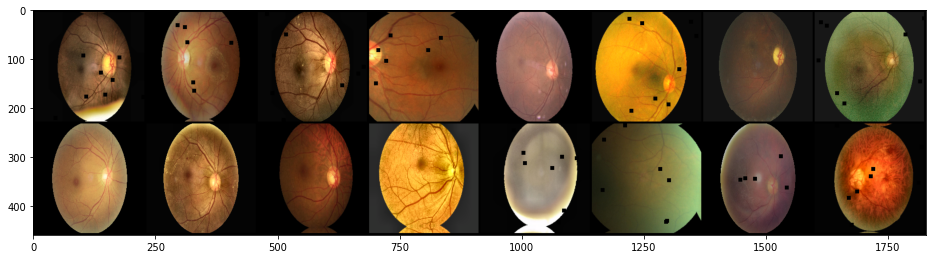

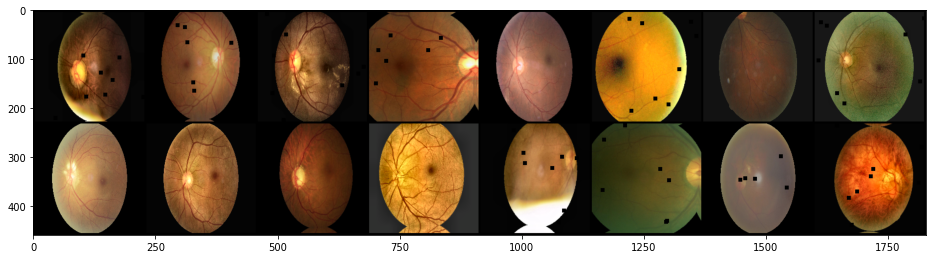

In [11]:
from torch.utils.data.dataloader import DataLoader
import torchvision
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(left,8,4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.figure(figsize=(16,16))
grid_img=torchvision.utils.make_grid(right,8,4)
plt.imshow(grid_img.permute(1, 2, 0))

In [12]:
# #test
# model = densenet121()
# x=torch.randn(1,3,224,224)
# l=model(x)
# r=model(x)
# x=torch.cat([l,r],dim=1)
# print(x.shape)
# l=nn.Linear(2000,1000)
# x=l(x)
# x.shape

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from torchvision.models import densenet121,resnet50
train_df,val_df=train_test_split(train_df,test_size=0.2,random_state=21)

In [26]:
import timm
class OurModel(LightningModule):
    def __init__(self):
        super(OurModel,self).__init__()
        #architecute
        self.model =  timm.create_model('resnet18d', pretrained=True)

        self.fc1=nn.Linear(2000,1000)
        self.relu=nn.ReLU()
        self.fc2= nn.Linear(1000,8)


        #parameters
        self.lr=1e-3
        self.batch_size=96
        self.numworker=8
        self.criterion=nn.BCEWithLogitsLoss(reduction='none')# internel sigmoid
        
    def forward(self,xl,xr):
        l=self.model(xl)
        r=self.model(xr)
        x=torch.cat((l,r),1)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.fc2(x)
        return x

    def focal(self,BCE,alpha=0.5,gamma=2):    
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
        return focal_loss.mean()
  
    def configure_optimizers(self):
        opt=torch.optim.Adam(self.parameters(), lr=self.lr,weight_decay=1e-4)
        scheduler = CosineAnnealingWarmRestarts(opt,T_0=5, T_mult=1, eta_min=1e-5, last_epoch=-1)
        return {'optimizer': opt,'lr_scheduler':scheduler,'monitor':'val_loss'}

    def train_dataloader(self):
        return DataLoader(DataReader(train_df,train_path,aug), batch_size = self.batch_size, 
                          num_workers=self.numworker,shuffle=True)

    def training_step(self,batch,batch_idx):
        left,right,label=batch
        out=self(left,right)
        loss=self.focal(self.criterion(out,label))
        self.log('train_loss', loss, on_epoch=True,prog_bar=True)
        return loss

    def val_dataloader(self):
        return DataLoader(DataReader(val_df,train_path,aug), batch_size = self.batch_size,
                          num_workers=self.numworker,  shuffle=False)

    def validation_step(self,batch,batch_idx):
        left,right,label=batch
        out=self(left,right)
        loss=self.focal(self.criterion(out,label))
        self.log('val_loss', loss, on_epoch=True,prog_bar=True)
        return loss


    def test_dataloader(self):
        return DataLoader(DataReader(val_df,train_path,aug), batch_size = self.batch_size,num_workers=self.numworker,  shuffle=False)

    def ODIR_Metrics(self,gt_data, pr_data):
        th = 0.5
        gt_data=gt_data.cpu().numpy()
        pr_data=pr_data.cpu().numpy()
        gt = gt_data.flatten()
        pr = pr_data.flatten()
        kappa = metrics.cohen_kappa_score(gt, pr>th)
        f1 = metrics.f1_score(gt, pr>th, average='micro')
        auc = metrics.roc_auc_score(gt, pr)
        acc=metrics.accuracy_score(gt, pr>th)
        final_score = (kappa+f1+auc)/3.0
        return kappa, f1, auc, final_score,acc

    def test_step(self, batch, batch_idx):
        left,right,label=batch
        out=self(left,right)
        loss=self.focal(self.criterion(out,label))
        return {'loss': loss, 'label': label.detach(), 'pred': out.detach()}

    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        label = torch.cat([x['label'] for x in outputs])
        pred = torch.cat([x['pred'] for x in outputs])
        kappa, f1, auc, final_score,acc = self.ODIR_Metrics(label,pred)
        self.log('kappa',np.round(kappa,3))
        self.log('f1',np.round(f1,3))
        self.log('auc',np.round(auc,3))
        self.log('final',np.round(final_score,3))
        self.log('acc',np.round(acc,3))



In [16]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')

early_stop_callback = EarlyStopping(monitor='val_loss',  patience=10, verbose=True, mode='min')
checkpoint_callback = ModelCheckpoint(monitor='val_loss',dirpath='',
                                      filename='savefile' )
model = OurModel()
trainer = Trainer(max_epochs=10, 
                  gpus=-1,precision=16,
                  callbacks=[checkpoint_callback,early_stop_callback,lr_monitor],
                  )


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [17]:
%%time
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.7 M
1 | fc1       | Linear            | 2.0 M 
2 | relu      | ReLU              | 0     
3 | fc2       | Linear            | 8.0 K 
4 | criterion | BCEWithLogitsLoss | 0     
------------------------------------------------
13.7 M    Trainable params
0         Non-trainable params
13.7 M    Total params
27.436    Total estimated model params size (MB)
/home/talha/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:623: UserWarning: Checkpoint directory  exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

/home/talha/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.042


Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.039


CPU times: user 16.9 s, sys: 2.51 s, total: 19.4 s
Wall time: 2min 22s


/home/talha/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [18]:
trainer.test()

/home/talha/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1393: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  rank_zero_warn(
Restoring states from the checkpoint path at savefile.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at savefile.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'acc': 0.8610000014305115,
 'auc': 0.8629999756813049,
 'f1': 0.8610000014305115,
 'final': 0.6029999852180481,
 'kappa': 0.08500000089406967}
--------------------------------------------------------------------------------


Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 245, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

[{'kappa': 0.08500000089406967,
  'f1': 0.8610000014305115,
  'auc': 0.8629999756813049,
  'final': 0.6029999852180481,
  'acc': 0.8610000014305115}]

In [19]:
# submission

In [59]:
submission_df=pd.read_csv('../multilabel/ODIR/XYZ_ODIR.csv')
submission_df.head()

,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,0,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0


In [28]:
test_path='../multilabel/ODIR/ODIR-5K_Testing_Images/'

In [31]:
loader=DataLoader(DataReader(submission_df,test_path,aug), batch_size = model.batch_size,num_workers=model.numworker,shuffle=False)
batch=next(iter(loader))
batch[0].shape,batch[1].shape

(torch.Size([96, 3, 224, 224]), torch.Size([96, 3, 224, 224]))

In [32]:
model=model.cuda()
preds=[]
with torch.no_grad():
    model.eval()
    for batch in loader:
        preds.append(model(batch[0].cuda(),batch[1].cuda()))

In [35]:
preds=torch.cat(preds)
preds.shape

torch.Size([500, 8])

In [37]:
preds=preds.detach().cpu().numpy()

In [44]:
preds=np.where(preds>0.5,1,0)#convert probabilities to target

In [60]:
for i,j in enumerate(submission_df.columns[1::]):
    submission_df[j]=preds[:,i]
    

In [61]:
submission_df.head()

,ID,N,D,G,C,A,H,M,O
0,937,0,0,0,0,0,0,0,0
1,967,0,1,0,0,0,0,0,0
2,988,0,0,0,0,0,0,0,0
3,995,0,0,0,0,0,0,0,0
4,1000,0,0,0,0,0,0,0,0
